In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'axes.linewidth'    : 0.4,
	                 'ytick.major.width' : 0.4,
                     'ytick.minor.width' : 0.4,
                     'xtick.major.width' : 0.4,
                     'xtick.minor.width' : 0.4,
                     'xtick.major.size'  : 4,
                     'ytick.major.size'  : 4,
                     'xtick.minor.visible' : 'True',
                     'ytick.minor.visible' : 'True',
                     'xtick.labelsize': 8, 
                     'ytick.labelsize': 8,
                     'axes.labelsize' : 8,
                     'font.family': 'sans-serif',
                     'figure.figsize': (15/3, 3.3),
                     'figure.dpi' : 200,
                     'ytick.right': 'True',
                     'xtick.top'  : 'True',
                     'ytick.direction': 'in',
                     'xtick.direction': 'in',
                     'axes.spines.top': 'True',
                     'axes.grid': 'False',
                     'grid.linestyle': '--',
                     'grid.linewidth': 0.25
                    })
sns.set_palette('deep')
import jax.numpy as jnp
import jax, jax.random as random

In [2]:
import sys
sys.path.append('../')
from emulator.utils import *
from emulator.dataloader import *
from emulator.layers import FiLMEmbeddingTransformer
from emulator.inference import infer_inputs

In [3]:
# If on GPU might need to set the matrix multiplication precision to high
# jax.config.update("jax_default_matmul_precision", "high")
# import os
# os.environ['XLA_FLAGS'] = (
#     '--xla_gpu_triton_gemm_any=True '
#     '--xla_gpu_enable_latency_hiding_scheduler=true ')

# Loading dataset

In [4]:
X = pd.read_csv('../data/rsp.bettergridsetc/features.dat', sep=r'\s+')
y = jnp.load('../data/rsp.bettergridsetc/targets.npy')
features = ['RSP_Z','RSP_X','RSP_mass','RSP_L','RSP_Teff','RSP_alfa']
X = jnp.array(X[features].values)
key1, key2 = random.split(random.PRNGKey(42))
X_train, y_train, X_test, y_test = train_test_split(key1, X, y, split=0.2, shuffle=False)
mu = X_train.mean(axis=0)
sd = X_train.std(axis=0)
std_y = y_train.std()
y_train = y_train/std_y
y_test = y_test/std_y
X_train = (X_train - mu)/sd
X_test = (X_test - mu)/sd
input_dim  = X_train.shape[1]
output_dim = y_train.shape[1]

In [5]:
model = FiLMEmbeddingTransformer(model_dim=256,ff_dim=512) # This is a small test model, need to update hyperparams/ modify the checkpoint back to saving them again
s = load_model('new_arch_res')
from functools import partial
body_fn = jax.jit(partial(model.apply, s['state']['params']))

/home/sk3365/.conda/envs/gpujax/lib/python3.13/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


# Initial Guess from `jax.scipy.optimize`

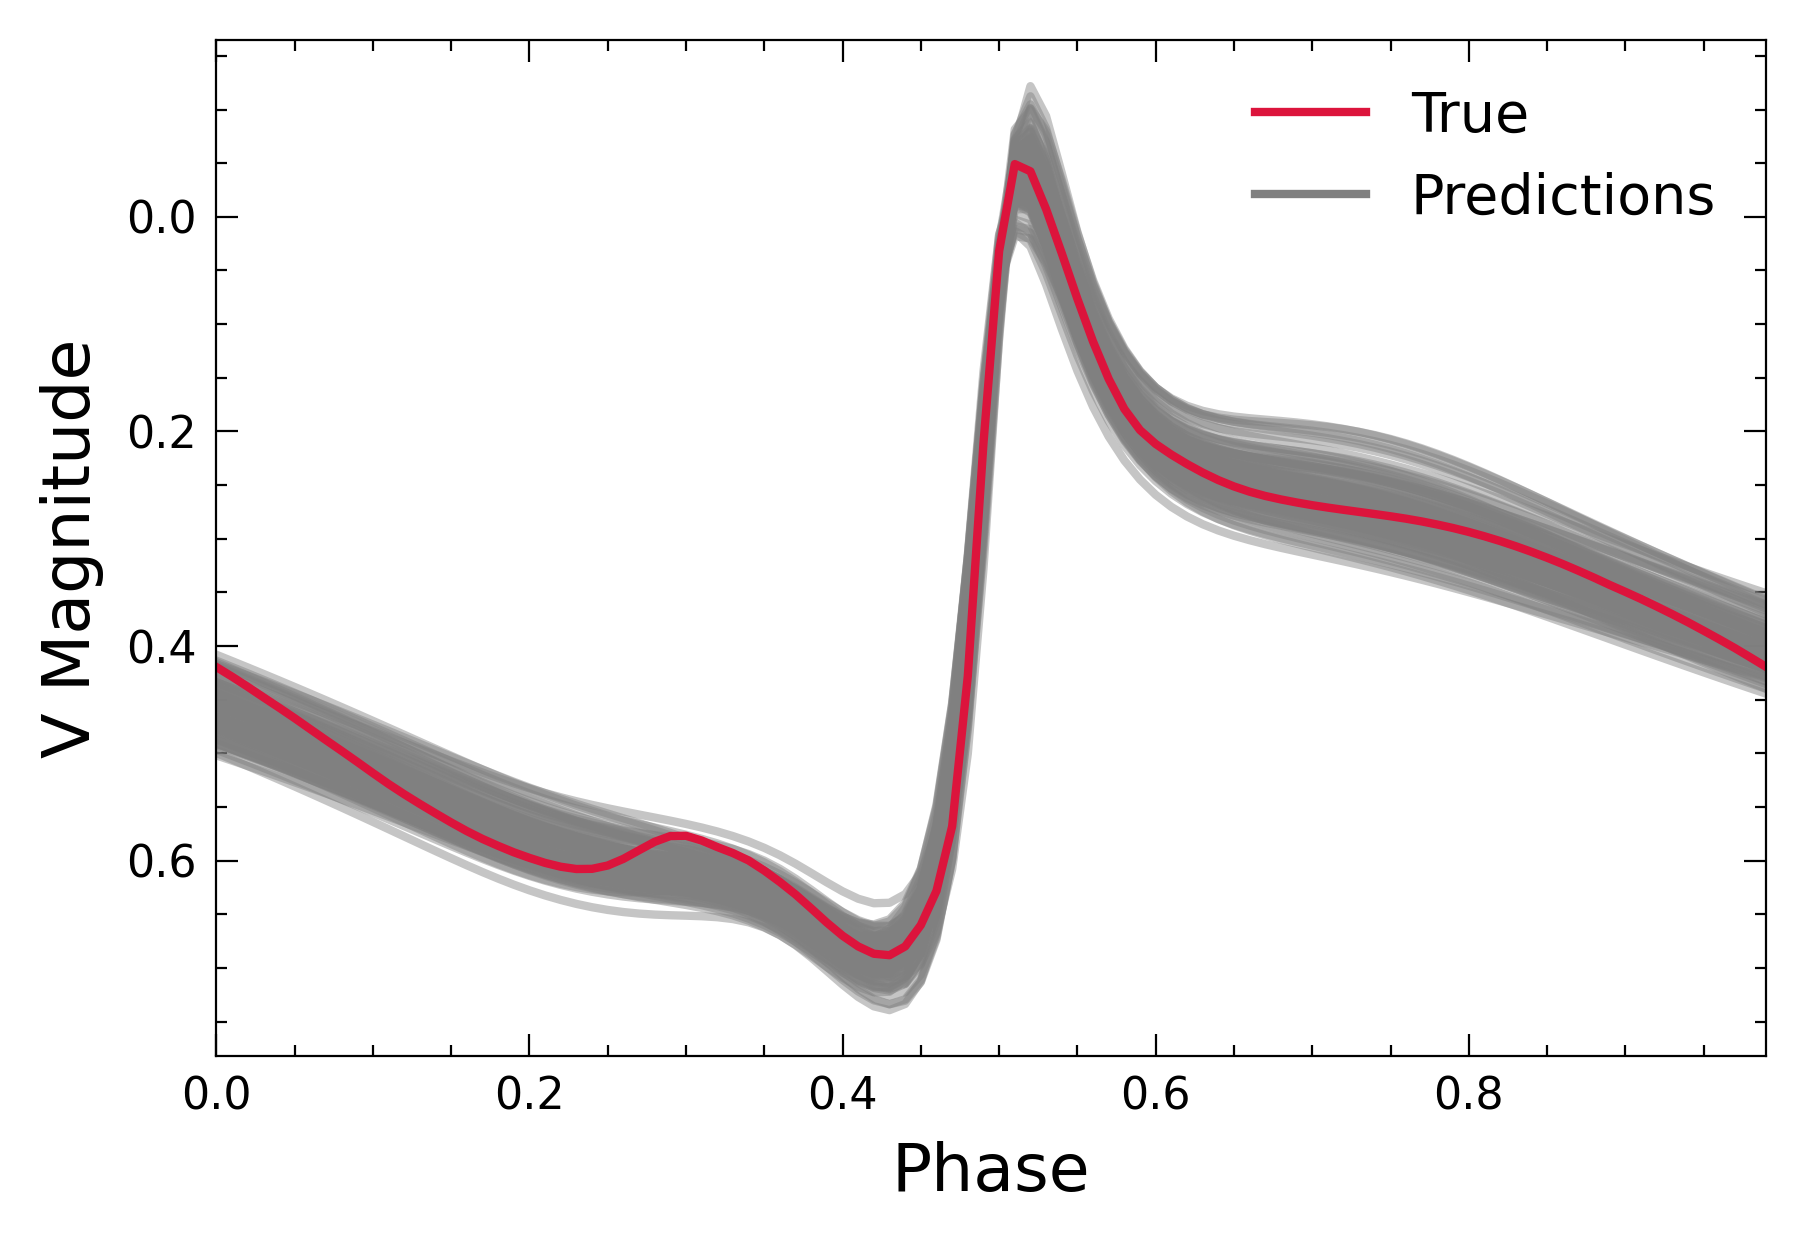

In [20]:
# The specific model i am looking at
mod = 2
y_pred = body_fn(X_train[mod].reshape(-1,6))
@jax.jit
def loss_fn(X):
    pred = body_fn(X.reshape(1,-1)).squeeze()
    return jnp.mean((pred - y_train[mod])**2)
X_init = jax.scipy.optimize.minimize(
        loss_fn, jnp.zeros(6), method='BFGS').x
x = X_init.reshape(-1,6)
x = jnp.repeat(x, 100, axis=0)
# Adding some assumed random noise to see what happens,
# we can do this in a better way later
x = x + 5e-2*random.normal(random.key(11),shape=(x.shape))
y_preds = body_fn(x)
y_preds.shape
phase = jnp.arange(100)/100
for pred in y_preds:
	plt.plot(phase, pred*std_y, alpha=0.45, c='grey')
plt.plot(phase, y_train[mod]*std_y, c='crimson', label='True')
plt.plot([], [], c='grey', label='Predictions')
plt.xlim(0,0.99)
plt.gca().invert_yaxis()
plt.ylabel('V Magnitude', fontsize=12)
plt.xlabel('Phase', fontsize=12)
plt.legend(frameon=False)
plt.savefig('nice-example.pdf', bbox_inches='tight')

# Hamiltonian Monte Carlo
# This does NOT work correctly as of right now
uses `jax.scipy.optimize` result as initial guess

In [7]:
from numpyro.infer import MCMC, NUTS, init_to_median
from numpyro.infer.initialization import init_to_value
import numpyro.distributions as dist
import numpyro

In [8]:
def loss_fn(X, y=None):
    pred = body_fn(X.reshape(1,-1)).squeeze()
    return jnp.mean((pred - y)**2)

X_init = jax.scipy.optimize.minimize(
    partial(loss_fn, y=y_test[100]), jnp.zeros(6), method='BFGS').x
init_params = {'features': X_init}

def model(y_obs):
	with numpyro.plate('f', 1):
	    X = numpyro.sample("features",
						   dist.ImproperUniform(dist.constraints.interval(-3,3),
											   event_shape=(6,), batch_shape=(1,)))
		
	pred = body_fn(X.reshape(1,-1)).squeeze()
	noise_scale = numpyro.sample("noise", dist.HalfNormal(0.01))
	numpyro.sample(
        "obs",
        dist.Normal(pred, noise_scale),
        obs=y_test
    )

In [9]:
num_warmup=2500
num_samples=500
nuts_kernel = NUTS(
    model,
    adapt_step_size=True,
    adapt_mass_matrix=True,
	init_strategy=init_to_value(values=init_params),
    target_accept_prob=0.99,
    max_tree_depth=12
)
mcmc = MCMC(
    nuts_kernel,
    num_warmup=num_warmup,
    num_samples=num_samples,
)

In [ ]:
key = random.key(42)
mcmc.run(
    rng_key=key,
    y_obs=y_test[100],
)

warmup:  21%|██        | 633/3000 [01:13<03:36, 10.92it/s, 31 steps of size 5.13e-02. acc. prob=0.98] 

In [ ]:
mcmc.print_summary()

In [ ]:
mcmc.get_samples()['features'].mean(axis=0), X_test[100], x[0]

# SVI
# Other option for inferring inputs, also does NOT work correctly as of right now

In [41]:
from numpyro.infer import SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation
import optax

In [45]:
num_steps = 100000
learning_rate = 5e-4

In [46]:
optimizer = optax.adamw(learning_rate)
guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
rng_key = random.key(42)
svi_result = svi.run(rng_key, num_steps, y_test[100], init_params=init_params)

params = svi_result.params
losses = svi_result.losses

100%|██████████| 100000/100000 [01:54<00:00, 870.34it/s, init loss: 3168764.0000, avg. loss [95001-100000]: 41137.2461]


In [91]:
params

{'auto_loc': Array([-0.06594701, -0.8795046 , -2.283314  , -0.00282233,  1.2653651 ,
        -0.92738193], dtype=float32)}